In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import numpy as np
import scanpy as sc
import scvelo as scv

In [5]:
adata = scv.datasets.pancreas()
adata

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

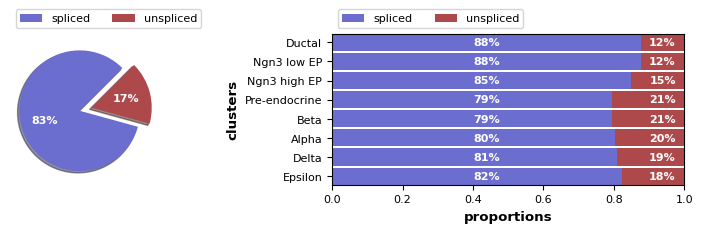

In [6]:
scv.pl.proportions(adata)

### Preprocess the Data

In [8]:
# def preprocess_sample(adata):
#     sc.pp.filter_cells(adata, min_genes=200)
#     sc.pp.filter_genes(adata, min_cells=3)
#     adata.var['mt'] = adata.var_names.str.startswith('MT-')
#     sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#     upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
#     lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
#     adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
#     adata = adata[adata.obs.pct_counts_mt < 20]
#     sc.pp.normalize_total(adata, target_sum=1e4)
#     sc.pp.log1p(adata)
#     sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # Default values
#     adata.raw = adata
#     adata = adata[:, adata.var.highly_variable] # Filter highly variable
#     sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
#     sc.pp.scale(adata, max_value=10)
#     sc.tl.pca(adata, svd_solver='arpack')
#     sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
#     sc.tl.leiden(adata, resolution=0.25)
#     sc.tl.umap(adata)
#     return 

def preprocess_sample(dataset):
    # scv.pp.filter_genes(dataset, min_shared_counts=20)
    # scv.pp.normalize_per_cell(dataset, enforce=True)
    # scv.pp.filter_genes_dispersion(dataset, n_top_genes=2000)
    # scv.pp.log1p(dataset)
    # scv.pp.moments(dataset, n_pcs=30, n_neighbors=30)
    scv.pp.filter_and_normalize(dataset, min_shared_cells=20, n_top_genes=2000)
    scv.pp.moments(dataset, n_pcs=30, n_neighbors=30)
    
    return dataset

In [9]:
adata = preprocess_sample(adata)

Filtered out 22533 genes that are detected in less than 20 cells (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Project the velocities

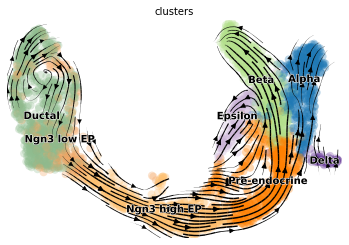

In [34]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

The velocity vector field displayed as streamlines yields fine-grained insights into the developmental processes. It accurately delineates the cycling population of ductal cells and endocrine progenitors. Further, it illuminates cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation.

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell. That reveals, e.g., the early endocrine commitment of Ngn3-cells (yellow) and a clear-cut difference between near-terminal α-cells (blue) and transient β-cells (green).

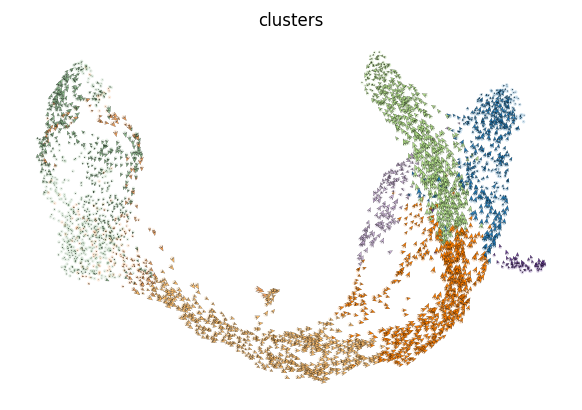

In [33]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

### Interprete the velocities

This is perhaps the most important part as we advise the user not to limit biological conclusions to the projected velocities, but to examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes.

See the gif here to get an idea of how to interpret a spliced vs. unspliced phase portrait. Gene activity is orchestrated by transcriptional regulation. Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait.

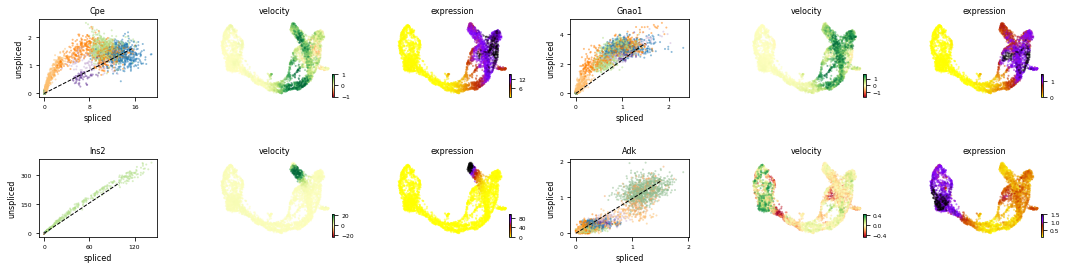

In [13]:
scv.pl.velocity(adata, ['Cpe', 'Gnao1', 'Ins2', 'Adk'], ncols=2)

The black line corresponds to the estimated ‘steady-state’ ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

For instance Cpe explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while Adk explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

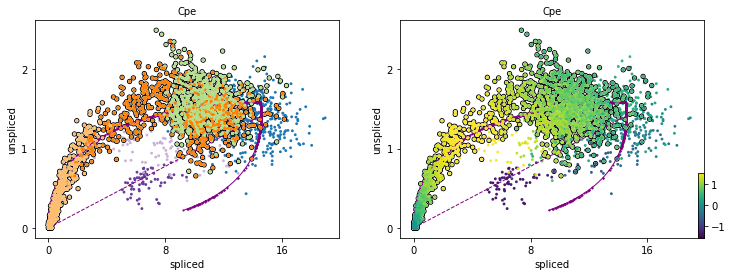

In [32]:
scv.pl.scatter(adata, 'Cpe', color=['clusters', 'velocity'],
               add_outline='Ngn3 high EP, Pre-endocrine, Beta')

### Identify important genes

We need a systematic way to identify genes that may help explain the resulting vector field and inferred lineages. To do so, we can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [14]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha    Delta  \
0  Notch2       Ptpn3        Pde1c           Pam     Pax6  Zcchc16    Zdbf2   
1    Sox5       Hacd1        Ptprs          Sdk1    Unc5c   Prune2   Spock3   
2   Krt19       Hspa8         Pclo        Baiap3     Nnat     Ksr2  Akr1c19   
3   Hspa8      Gm8113     Rap1gap2         Abcc8  Tmem108    Chrm3    Ptprt   
4    Ano6       Kcnq1        Ttyh2          Gnas    Ptprt     Cdh2   Snap25   

  Epsilon  
0   Tmcc3  
1    Ica1  
2   Ncoa7  
3   Srrm3  
4  Mamld1

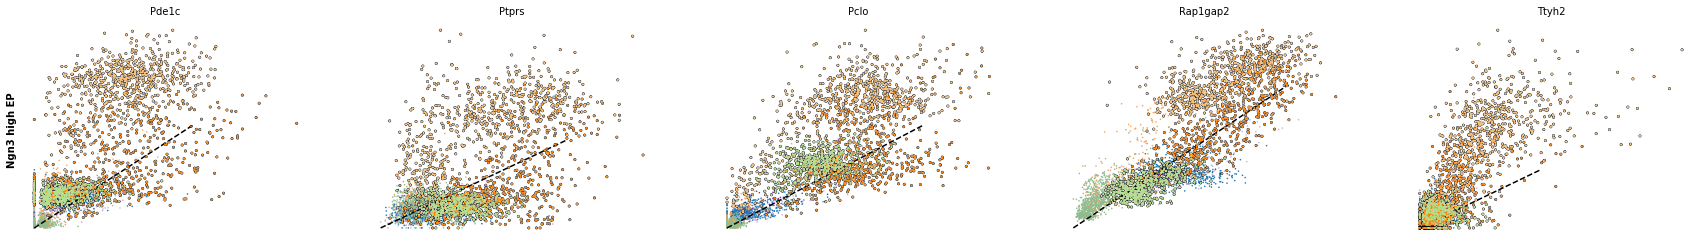

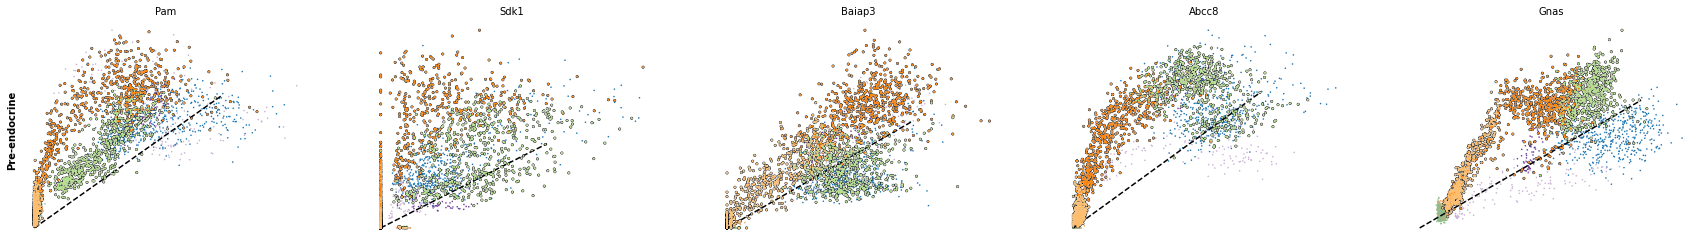

In [15]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

### Velocities in cycling progrenitors

The cell cycle detected by RNA velocity, is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


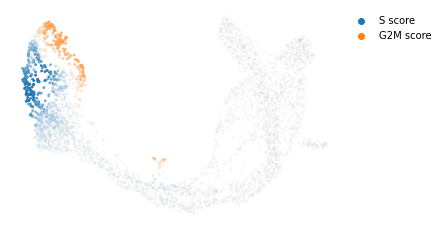

In [16]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

For the cycling Ductal cells, we may screen through S and G2M phase markers. The previous module also computed a spearmans correlation score, which we can use to rank/sort the phase marker genes to then display their phase portraits.

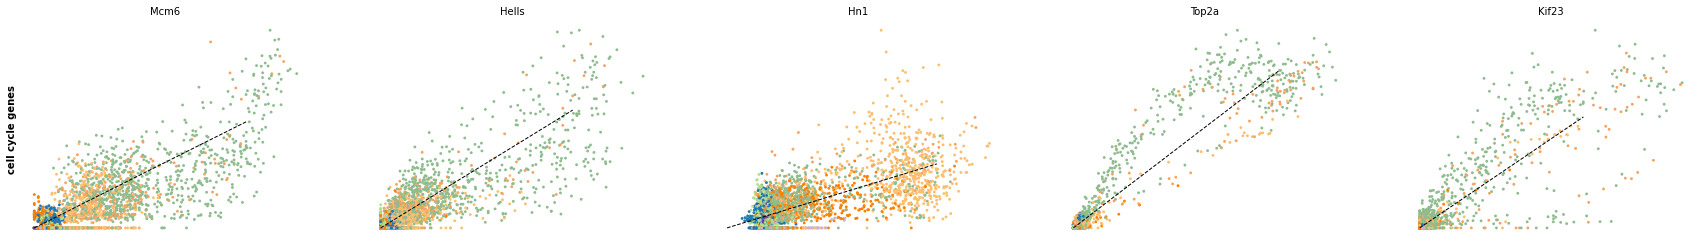

In [17]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

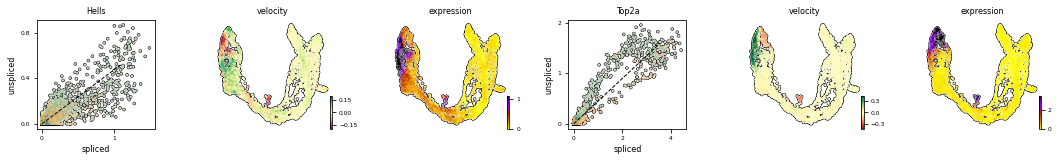

In [18]:
scv.pl.velocity(adata, ['Hells', 'Top2a'], ncols=2, add_outline=True)

### Speed and coherence
Two more useful stats: 
- The speed or rate of differentiation is given by the length of the velocity vector. 
- The coherence of the vector field (i.e. how a velocity vector correlates with its neighbouring velocities) provides a measure of confidence

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


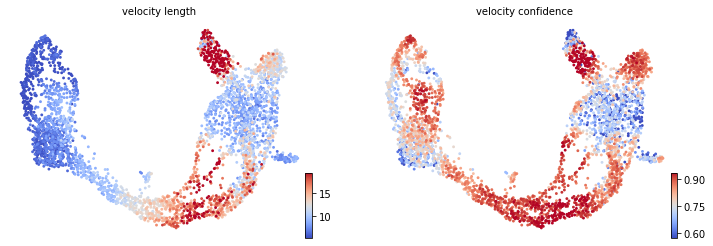

In [19]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

On cluster-level, we find that differentiation substantially speeds up after cell cycle exit (Ngn3 low EP), keeping the pace during Beta cell production while slowing down during Alpha cell production.

In [20]:
df = adata.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

### Velocity graph and pseudotime

Visualize the velocity graph to portray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probability transitions by setting a threshold. The graph, for instace, indicates two phases of Episilon cell production, coming from early and late Pre-endocrine cells.

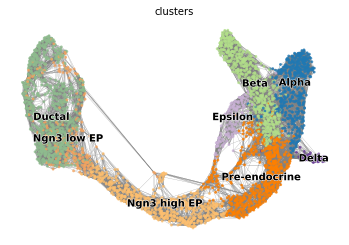

In [21]:
scv.pl.velocity_graph(adata, threshold=.1)

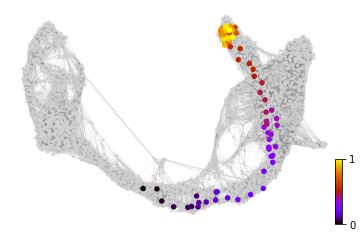

In [22]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


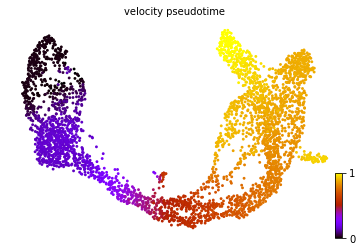

In [23]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

### PAGA velocity graph
PAGA graph abstraction has benchmarked as top-performing method for trajectory inference.

In [24]:
! pip install python-igraph --upgrade --quiet

In [25]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


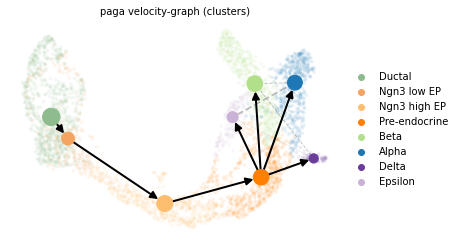

In [26]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

## Dynamic Modeling
Dynamic modelling allow for the learning of the full transcriptional dynamics of splicing kinetics

It is solved using a likelihood-based expectation-maximization framework, by iteratively estimating the parameters of reaction rates and latent cell-specific vaiables, i.e. transcriptional state and cell-internal latent time. It aims to learn the unspliced/spliced phase trajectory for each gene

In [29]:
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata, n_jobs=-1)

recovering dynamics (using 4/4 cores)


  0%|          | 0/789 [00:00<?, ?gene/s]

    finished (0:02:56) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


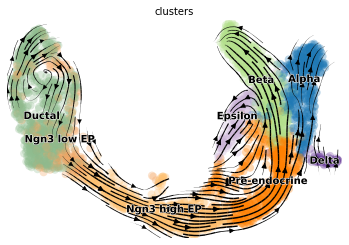

In [30]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Kinetic rate parameters
The rates of RNA transcription, splicing and degradation are estimated without the need of any experimental data
They can be useful to better understand the cell identiy and phenotypic heterogeneity

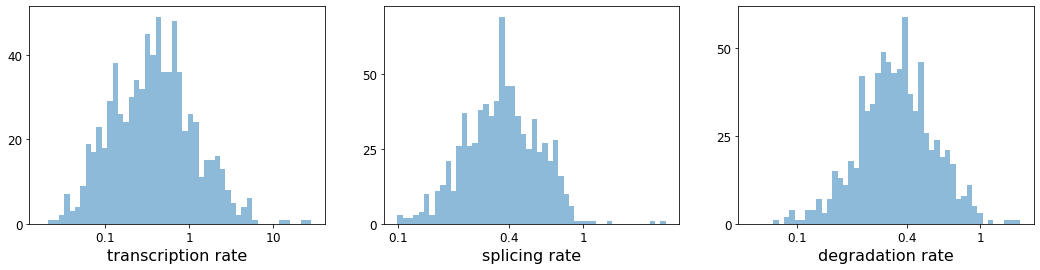

fit_alpha  fit_beta  fit_gamma  fit_t_  fit_scaling  fit_std_u  \
index                                                                     
Sbspon        0.46  2.44e+00       0.38    3.79         0.15       0.06   
Fam135a       0.17  1.18e-01       0.20   11.24         1.12       0.36   
Adgrb3        0.05  6.75e-03       0.20    6.99        71.85       2.15   
Uggt1         0.19  1.28e+00       0.25    9.64         0.31       0.04   
Tbc1d8        0.08  1.18e-01       0.23   11.25         2.81       0.23   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
index                                                                 
Sbspon        0.18            0.25     0.0     0.0             0.18   
Fam135a       0.15            0.28     0.0     0.0             0.39   
Adgrb3        0.03            0.25     0.0     0.0             0.07   
Uggt1         0.16            0.20     0.0     0.0             0.42   
Tbc1d8        0.08            0.25     0.0     0.0             0.39   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
index                                                                      
Sbspon           0.16          0.43          0.67                   1.19   
Fam135a          1.35          0.39          0.67                   3.39   
Adgrb3           5.21          0.09          0.56                   1.89   
Uggt1            0.12          0.55          1.27                   2.83   
Tbc1d8           0.66          0.24          0.83                   2.91   

         fit_r2  
index            
Sbspon     0.62  
Fam135a    0.38  
Adgrb3     0.38  
Uggt1      0.06  
Tbc1d8     0.61

In [31]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

### Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


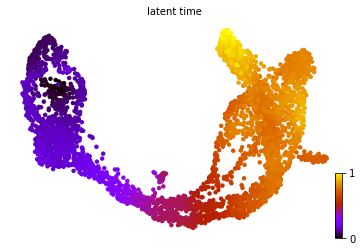

In [35]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

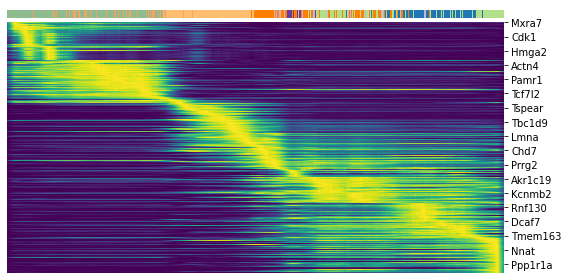

In [36]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

### Top-likelihood genes
Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model.

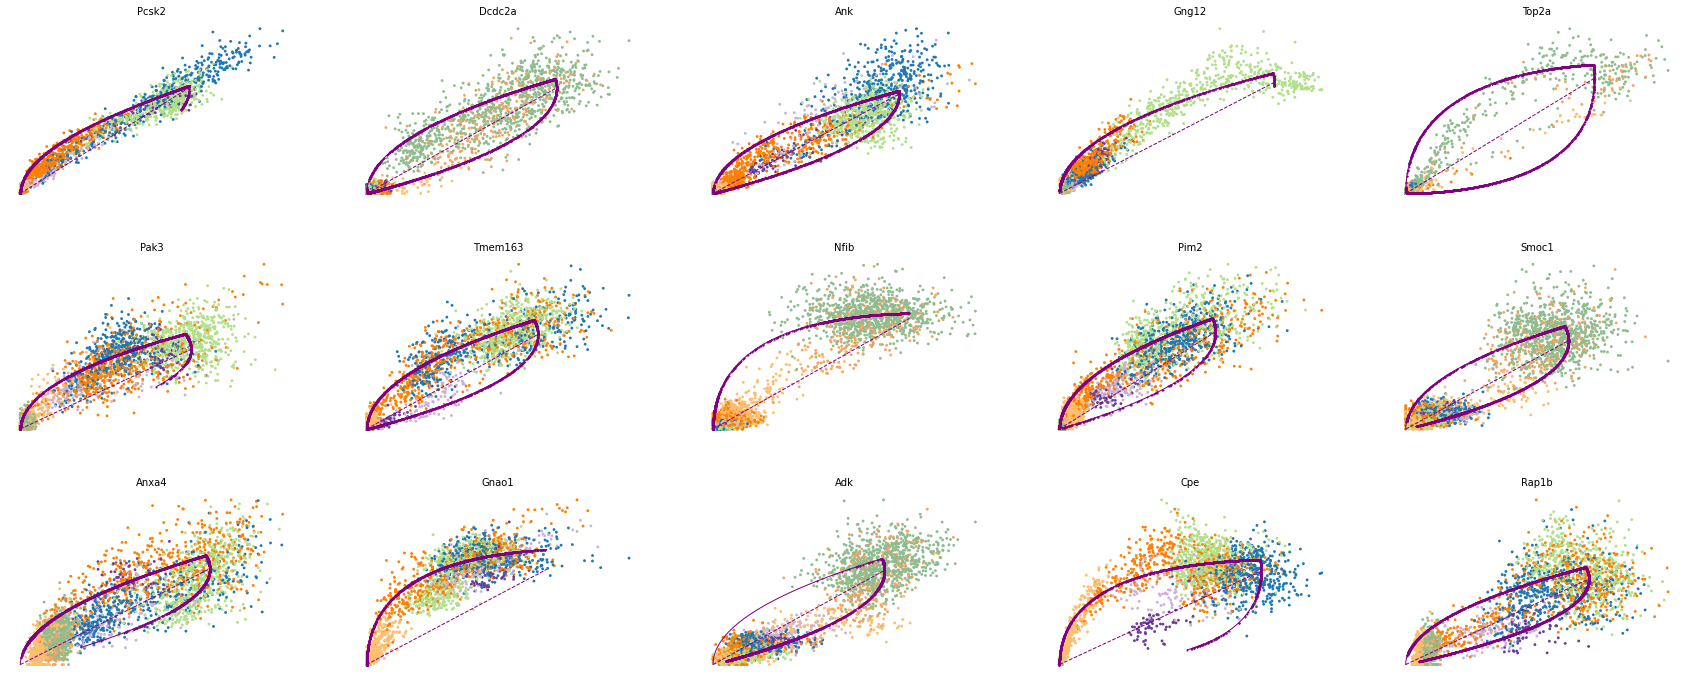

In [37]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

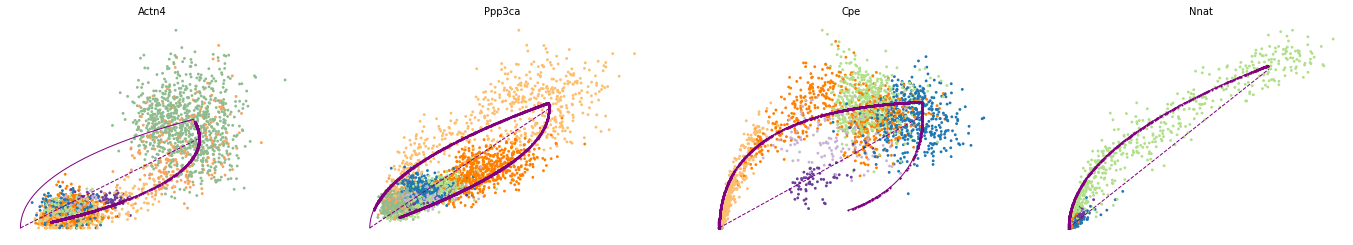

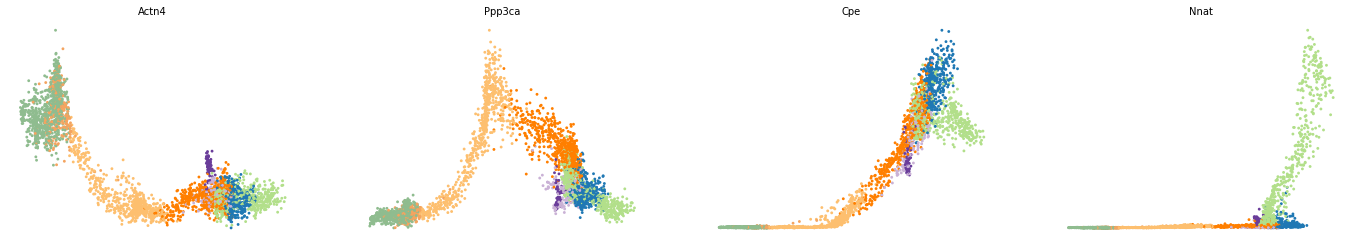

In [38]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

### Cluster-specific top-likelihood genes

Moreover, partial gene likelihoods can be computed for a each cluster of cells to enable cluster-specific identification of potential drivers.

In [39]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:02) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta  Alpha   Delta  \
0   Dcdc2a      Dcdc2a       Rbfox3         Abcc8    Pcsk2    Cpe   Pcsk2   
1    Top2a         Adk       Mapre3       Tmem163      Ank  Gnao1   Rap1b   
2     Nfib       Mki67       Btbd17         Gnao1  Tmem163   Pak3    Pak3   
3  Wfdc15b    Rap1gap2        Sulf2           Ank   Tspan7   Pim2   Abcc8   
4     Cdk1       Top2a        Tcp11        Tspan7    Map1b  Map1b  Klhl32   

    Epsilon  
0      Tox3  
1    Rnf130  
2     Meis2  
3       Adk  
4  Rap1gap2

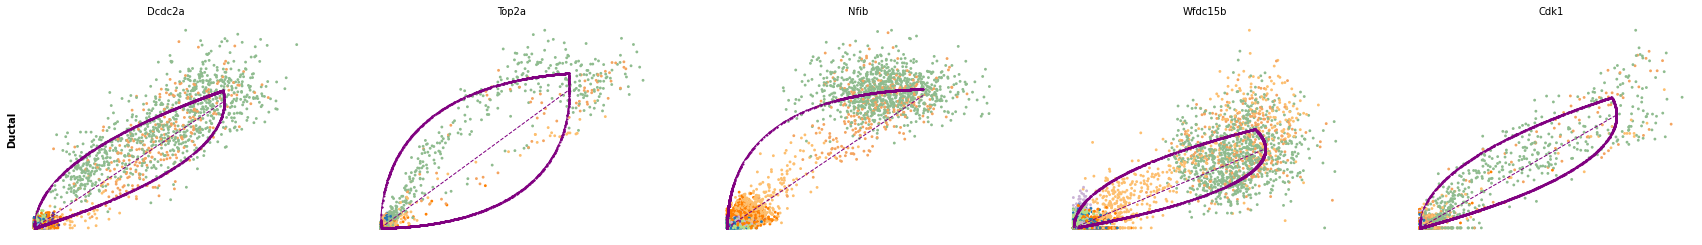

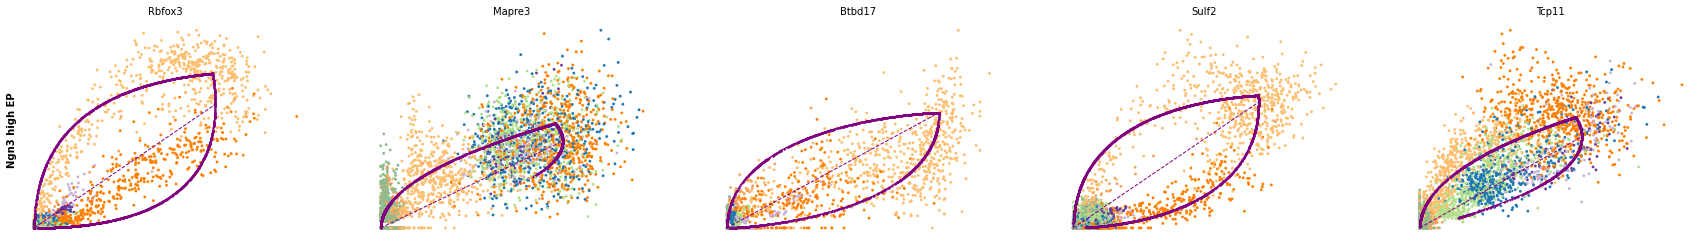

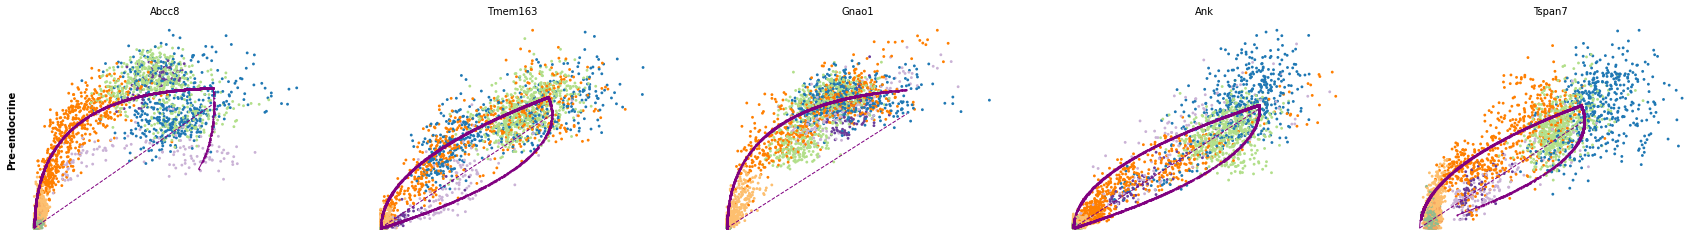

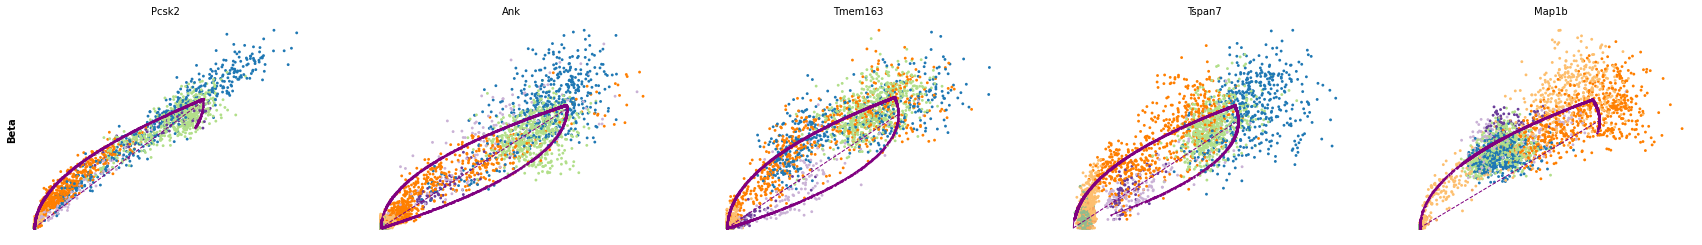

In [40]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)

## Differential Kinetics

Distinct cell types and lineages may exhibit different kinetics regimes as these can be governed by a different network structure. Even if cell types or lineages are related, kinetics can be differential due to alternative splicing, alternative polyadenylation and modulations in degradation.

The dynamical model allows us to address this issue with a likelihood ratio test for differential kinetics to detect clusters/lineages that display kinetic behavior that cannot be sufficiently explained by a single model for the overall dynamics. Each cell type is tested whether an independent fit yields a significantly improved likelihood.

The likelihood ratio, following an asymptotic chi-squared distribution, can be tested for significance. Note that for efficiency reasons, by default an orthogonal regression is used instead of a full phase trajectory to test whether a cluster is well explained by the overall kinetic or exhibits a different kinetic.

Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


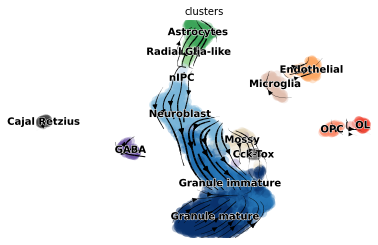

In [50]:
datum = scv.datasets.dentategyrus()
scv.pp.filter_and_normalize(datum, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(datum, n_pcs=30, n_neighbors=30)

scv.tl.velocity(datum)
scv.tl.velocity_graph(datum)

scv.pl.velocity_embedding_stream(datum, basis='umap')

### Differential Kinetic Test

Distinct cell types and lineages may exhibit different kinetics regimes as these can be governed by a different network structure. Even if cell types or lineages are related, kinetics can be differential due to alternative splicing, alternative polyadenylation and modulations in degradation.

The dynamical model allows us to address this issue with a likelihood ratio test for differential kinetics to detect clusters/lineages that display kinetic behavior that cannot be sufficiently explained by a single model for the overall dynamics. Each cell type is tested whether an independent fit yields a significantly improved likelihood.

The likelihood ratio, following an asymptotic chi-squared distribution, can be tested for significance. Note that for efficiency reasons, by default an orthogonal regression is used instead of a full phase trajectory to test whether a cluster is well explained by the overall kinetic or exhibits a different kinetic.

In [57]:
var_names = ['Tmsb10', 'Fam155a', 'Hn1', 'Rpl6']
scv.tl.differential_kinetic_test(datum, var_names=var_names, groupby='clusters')

testing for differential kinetics
    finished (0:00:00) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)

outputs model fit of gene: Rpl6


In [58]:
scv.get_df(datum[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

fit_diff_kinetics  fit_pval_kinetics
index                                       
Tmsb10        Endothelial           1.23e-12
Fam155a     Cajal Retzius          2.19e-180
Hn1             Microglia           3.12e-03
Rpl6            Microglia           7.98e-16

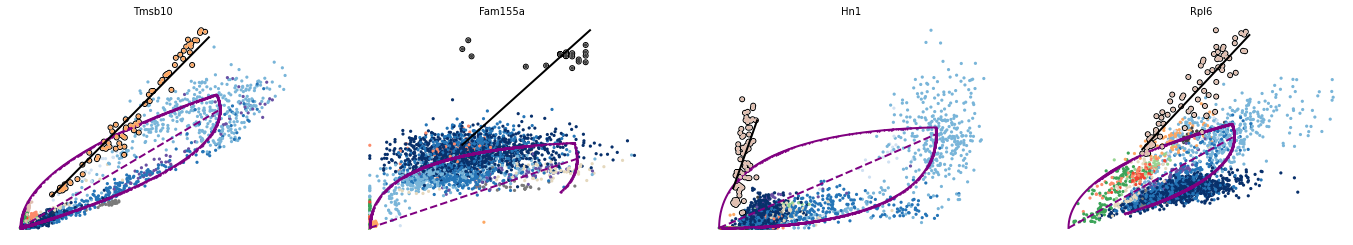

In [59]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(datum, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)

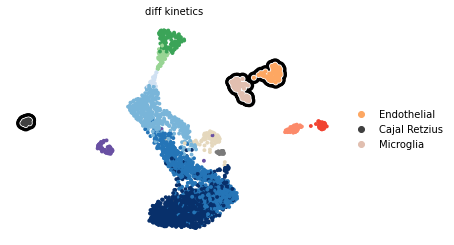

In [60]:
diff_clusters=list(datum[:, var_names].var['fit_diff_kinetics'])
scv.pl.scatter(datum, legend_loc='right', size=60, title='diff kinetics',
               add_outline=diff_clusters, outline_width=(.8, .2))

### Testing top-likelihood genes

Screening through the top-likelihood genes, we find some gene-wise dynamics that display multiple kinetic regimes.



In [61]:
scv.tl.recover_dynamics(adata, n_jobs=-1)

recovering dynamics (using 4/4 cores)


  0%|          | 0/789 [00:00<?, ?gene/s]

    finished (0:03:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [62]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='clusters')

testing for differential kinetics
    finished (0:00:19) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


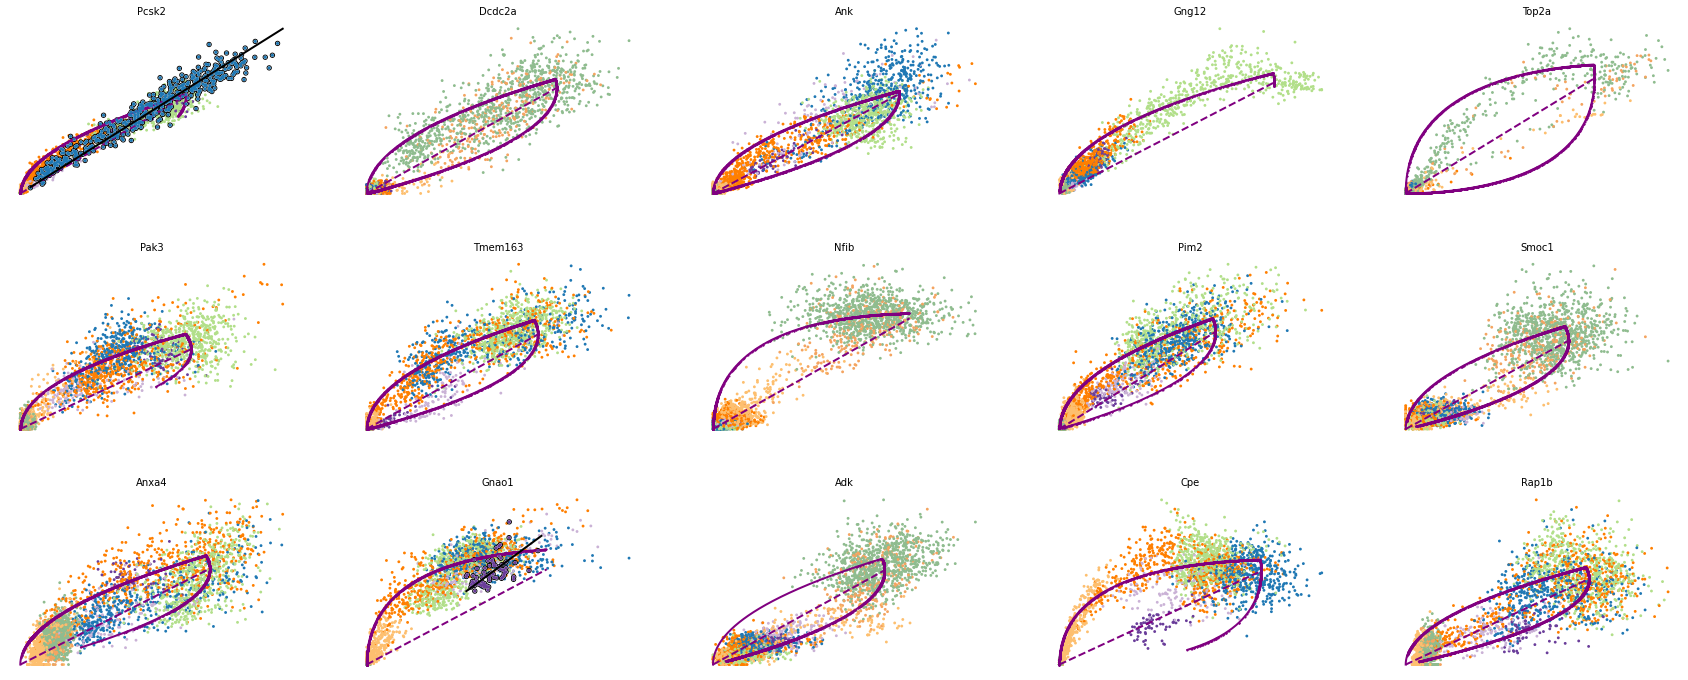

In [63]:
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

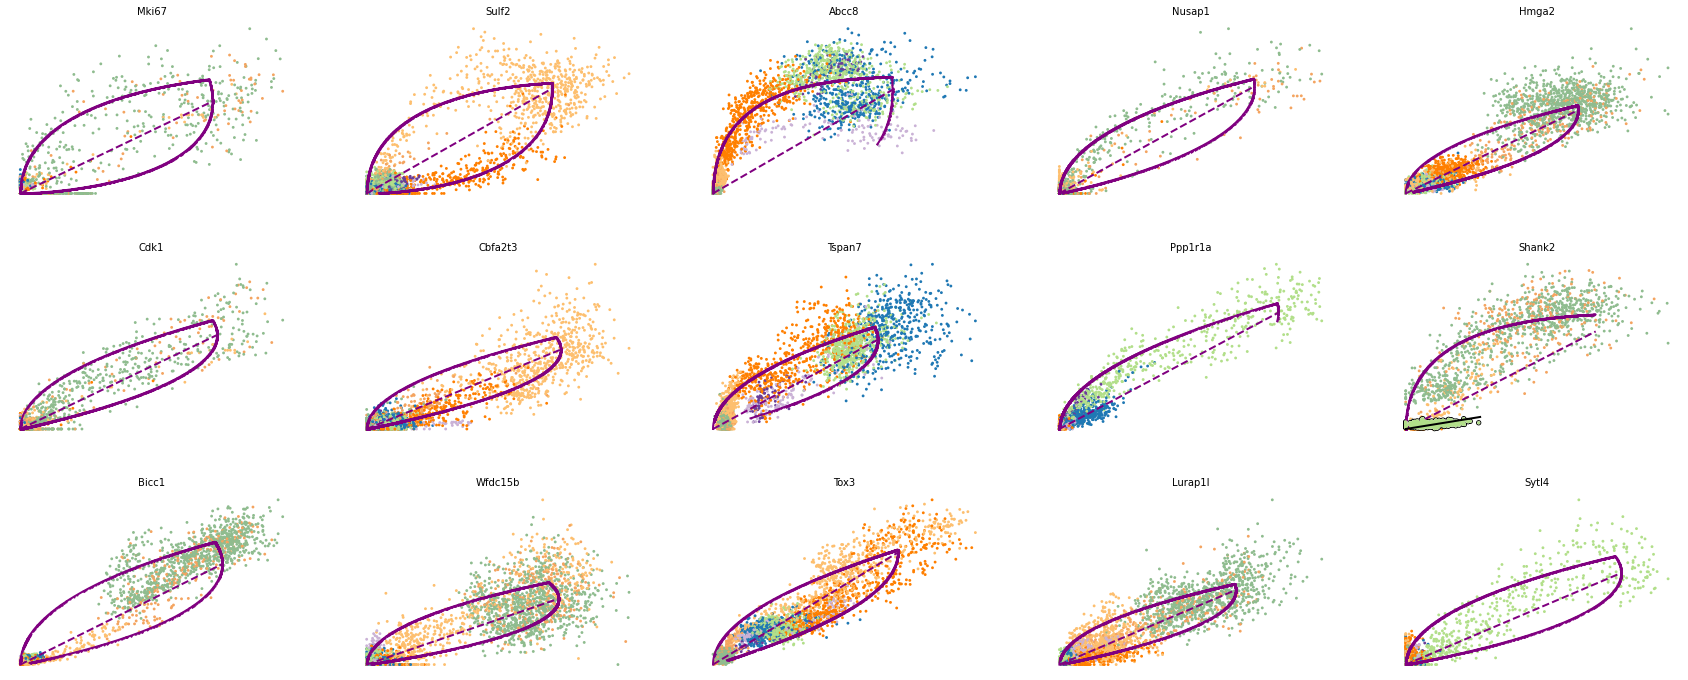

In [64]:
scv.pl.scatter(adata, basis=top_genes[15:30], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

### Recompute velocities
Finally, velocities can be recomputed leveraging the information of multiple competing kinetic regimes.

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


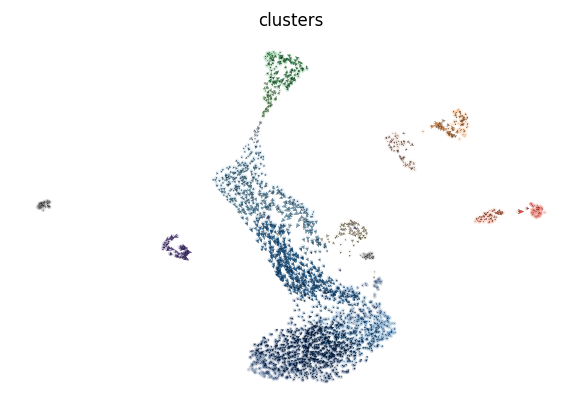

In [65]:
scv.tl.velocity(datum, diff_kinetics=True)
scv.tl.velocity_graph(datum)
scv.pl.velocity_embedding(datum, dpi=120, arrow_size=2, arrow_length=2)